# BT4222 Final Project

## COVID-19 Fake News Classifier

Group 13

## Importing Packages

In [107]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import save,load
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, precision_score, recall_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import Word2Vec
import gensim

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import utils, layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Ensemble
import xgboost
from sklearn.ensemble import RandomForestClassifier

# Probabilistic 
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Online
from sklearn.linear_model import PassiveAggressiveClassifier


# Support
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import gc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Settings

In [2]:
# SETTINGS
GOOGLE_COLAB = False # If using Google Colab, set to true, else false.
RANDOM_STATE = 42

# DATASET
TRAIN_SIZE = 0.8

#SETTINGS
RANDOM_STATE = 42

#DATASET
TRAIN_SIZE = 0.8

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# TENSORFLOW
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

gc.collect()

0

## Loading Datasets

In [3]:
train_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Train.csv")
val_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Val.csv")
df = pd.concat([train_ds,val_ds]).reset_index()

In [4]:
df.head()

,index,id,tweet,label
0,0,1,The CDC currently reports 99031 deaths. In gen...,real
1,1,2,States reported 1121 deaths a small rise from ...,real
2,2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,4,5,Populous states can generate large case counts...,real


In [5]:
df.label.unique()

array(['real', 'fake'], dtype=object)

In [6]:
df = df.drop('id', axis=1)

## Sanity Check




In this section, we check for:
1.   Null inputs
2.   Duplicated rows

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8560 entries, 0 to 8559
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   8560 non-null   int64 
 1   tweet   8560 non-null   object
 2   label   8560 non-null   object
dtypes: int64(1), object(2)
memory usage: 200.8+ KB


In [8]:
df.duplicated().sum()

0

In [9]:
df.label.value_counts()

real    4480
fake    4080
Name: label, dtype: int64

<AxesSubplot:>

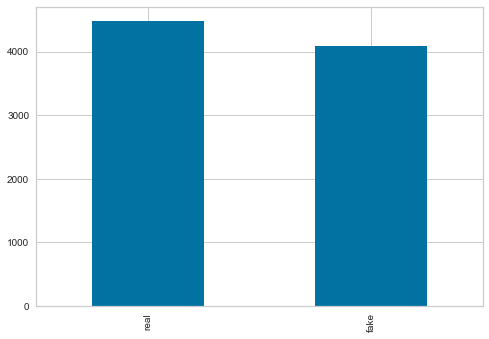

In [10]:
df.label.value_counts().plot(kind='bar')

## Data Pre-processing

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()

In [12]:
", ".join(stop_words)


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

### Previewing Tweets

In [13]:
print(df.tweet.sample(15).values)

['States are in the dark about available beds and ICU capacity after the White House halted #COVID19 reports to the CDC. https://t.co/89HAk004ue'
 'Thankful to Montana business leaders stepping up to keep us safe. "If strict stay-at-home protocols are followed for the next three months the model shows a peak June 15 with 59 hospitalizations." via @DailyInterLake https://t.co/ayFKe7keT0'
 '#IndiaFightsCorona: A total of 86961 new cases have been reported in the last 24 hours in the country. 76% of the new confirmed cases are concentrated in 10 States/UTs. #StaySafe #IndiaWillWin https://t.co/3Wt2zkKKy4'
 'Claim: Cow urine/dung could treat COVID-19: Assam legislator Haripriya https://t.co/6EIJ9P1TJv Fact: Such claims only add to misinformation/fear-mongering should fight disease scientifically: Anant Bhan health researcher. No preventive med/cure yet: WHO https://t.co/b3QfVqWv7U'
 '#IndiaFightsCorona: As many as 1130 deaths have been registered in the past 24 hours. 10 States/UTs account

### Creating a column for word count

In [14]:
df['length'] = df['tweet'].apply(lambda x: len(x.split()))

### Preliminary Length Analysis

In [15]:
df['length'].describe()

count    8560.00000
mean       26.94778
std        22.45087
min         3.00000
25%        15.00000
50%        25.00000
75%        37.00000
max      1456.00000
Name: length, dtype: float64

<AxesSubplot:>

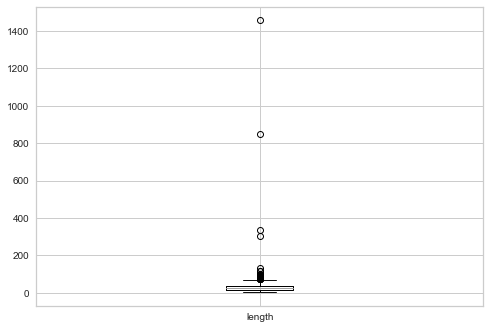

In [16]:
df.boxplot(column=['length'])

We notice outliers with extreme number of words. Previewing outlier articles here.

In [17]:
df[df['length']>150]

,index,tweet,label,length
270,270,"Amoxi"" Capsule made in US is the only medicine...",fake,1456
1109,1109,"Actors"" applauded Macron when he visited the s...",fake,847
6306,6306,Man visited Albany N.Y. days before dying from...,fake,336
8153,1733,I'm so happy that we’re able to do something v...,real,304


In [18]:
for tweet in df['tweet'][df['length']>150].values:
  print(tweet)

Amoxi" Capsule made in US is the only medicine that can completely cure COVID-19.
Egyptian Health Minister arrive in Italy with secret coronavirus cure.
 Dr Charles Lieber a Harvard professor has been arrested in the USA for manufacturing the coronavirus and selling it to China. A video news report from WCVB a TV station in Boston Massachusetts is shared with the Facebook post.
Mountain Matterhorn in Switzerland was lit in three colours of Indian flag as a token of gratitude to India for sending Hydroxychloroquine.
Al-Azhar Imam said he is considering exceptions on Ramadan fasting as the research says that the mouth must be kept wet to prevent COVID-19
 Japanese Nobel Tasuku Honjo says coronavirus was created in the Wuhan laboratory
A man collapses in 5 minutes after showing COVID-19 symptoms in India.
Celebrities spreading misinformation about coronavirus and the Janata curfew in India.
 Multiple posts shared repeatedly on Facebook and Twitter since March 2020 claim that Israel has re

We will remove the outlier articles to reduce noise when building our models.

In [19]:
df = df[df['length'] < 150]

(0.0, 200.0)

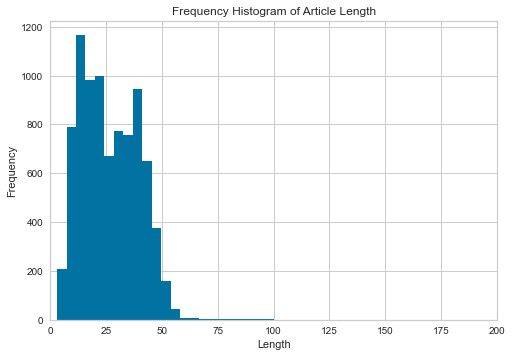

In [20]:
plt.hist(df['length'],bins=30)
plt.gca().set(title='Frequency Histogram of Article Length', ylabel='Frequency', xlabel='Length')
plt.xlim(0,200)


### Text Cleaning

- Transform to lowercase
- Remove trailing white spaces
- Remove stopwords
- Stem and lemmatize words to root form

In [21]:
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmer.lemmatize(stemmer.stem(token)))
    return " ".join(tokens)

In [22]:
df.tweet = df.tweet.apply(lambda x:preprocess(x))

In [23]:
print(df.tweet.sample(15).values)

['indiafightscorona 8 lakh averag test everi day india scale covid 19 test test per million tpm 27000 staysaf indiawillwin'
 'polic personnel infect coronavirus bihar hajipur'
 'accord vegetarian affect coronavirus need anim fat bodi surviv'
 'inhal hot water steam kill coronavirus'
 'italian mp sara cunial say bill gate kill peopl vaccin termin seed behind covid 19 pandem'
 'doctor give rescu pack peopl pre exist respiratori condit'
 'news racist furious suggest wear muslim style face veil fight dead coronavirus'
 'cdelis benzorn tri maxim transpar given wild uneven qualiti data come state site explain number tabl alexismadrig'
 'coronavirus live 12 hour surfac'
 'nashvill man momentarili lap polit correct regular correct health coronavirus'
 'see latest cdc covidview report new data covid19 like ill hospit rate death check'
 'video news report claim whatsapp go suspend brazil caption state suspens go take place misinform regard covid 19'
 'updat minhealthnz new case covid 19 report t

## Exploratory Data Analysis

### Length Analysis

<AxesSubplot:title={'center':'length'}, xlabel='label'>

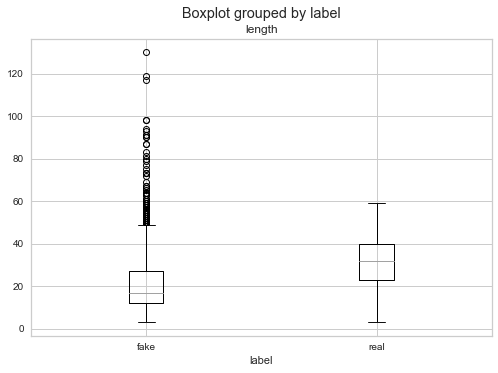

In [24]:
df.boxplot(column=["length"], by="label")

<AxesSubplot:xlabel='length', ylabel='Density'>

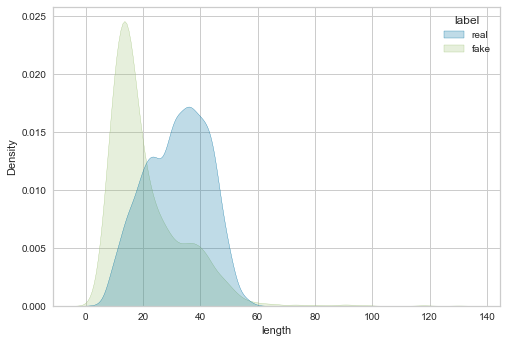

In [25]:
sns.kdeplot(data=df, x="length", hue="label", shade=True)

Fake news tends to be short than real news. 

### Word Clouds

#### Setting word exclusions from our wordclouds

In [26]:
cloud_stop = set(STOPWORDS)
cloud_stop.update(["covid", "coronavirus", "case", "covid-19", "peopl", "covid19", "amp"])

In [27]:
def generate_wordcloud(text):
    wordcloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

#### Word Cloud for ALL text

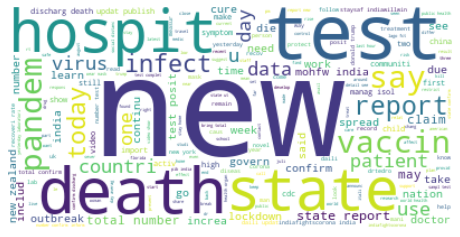

In [28]:
all_text = " ".join(tweet for tweet in df.tweet)
generate_wordcloud(all_text)

#### Word Cloud for Fake News

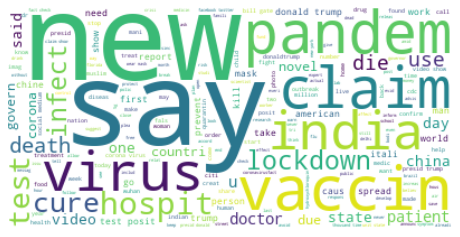

In [28]:
fake_text = " ".join(tweet for tweet in df[df['label']== 'fake'].tweet)
generate_wordcloud(fake_text)

#### Word Cloud for Real News

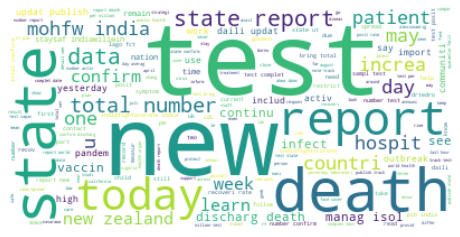

In [29]:
real_text = " ".join(tweet for tweet in df[df['label']== 'real'].tweet)
generate_wordcloud(real_text)

## Preparing Training and Testing Data

In [30]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)
print("TRAIN size: ", len(df_train))
print("TEST size: ", len(df_test))

TRAIN size:  6844
TEST size:  1712


### Label Encoding

In [31]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train  = encoder.transform(df_train.label.tolist())
y_test  = encoder.transform(df_test.label.tolist())

y_train  = y_train .reshape(-1,1)
y_test  = y_test.reshape(-1,1)

In [32]:
print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (6844, 1)
y_test (1712, 1)


## Text Vectorisation Methods

### Count Vectorisation

In [33]:
count_vectorizer = CountVectorizer()
x_train_countv = count_vectorizer.fit_transform(df_train.tweet).astype(np.float64)
x_test_countv = count_vectorizer.transform(df_test.tweet).astype(np.float64)

#### Previewing Vocabulary

In [34]:
pd.DataFrame(count_vectorizer.vocabulary_, index=[0]).T

,0
nasser,7401
ziberi,11036
test,10015
posit,8212
covid,3796
...,...
danielleiwood,3974
bleak,2863
bankofamerica,2638
mandetta,6870


### TF-IDF Vectorisation

#### Vectorising Text Using TF-IDF Vectorizer

In [35]:
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(df_train.tweet)
x_test_tfidf = tfidf_vectorizer.transform(df_test.tweet)

#### Previewing Sparse TF-IDF Vector

In [36]:
train_tfidf_sklearn = pd.DataFrame(x_train_tfidf.toarray(),columns=tfidf_vectorizer.get_feature_names_out())
train_tfidf_sklearn.sort_index().round(decimals=5)
train_tfidf_sklearn 

,00,000,006,00ice,00pm,01,011,0141,02,03,...,zoo,zoodirector,zookeep,zoolog,zoom,zoonot,zuckoff,zurich,zydus,zyphr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Previewing Words with Highest TFIDF Score

In [37]:
train_tfidf_sklearn = train_tfidf_sklearn.stack().reset_index()
train_tfidf_sklearn = train_tfidf_sklearn.rename(columns={0:'tfidf', 'level_0': 'id','level_1': 'term', 'level_2': 'term'})
train_tfidf_sklearn_sorted = train_tfidf_sklearn.sort_values(by=['id','tfidf'], ascending=[True,False]).groupby(['id'])


In [38]:
train_tfidf_sklearn_sorted.head(10)

,id,term,tfidf
7401,0,nasser,0.644215
11036,0,ziberi,0.644215
8212,0,posit,0.284045
10015,0,test,0.196617
488,0,19,0.164663
...,...,...,...
75656208,6843,00,0.000000
75656209,6843,000,0.000000
75656210,6843,006,0.000000
75656211,6843,00ice,0.000000


In [39]:
gc.collect()

0

### Word2Vec Model

#### Building Documents

In [40]:
documents = [tweet.split() for tweet in df_train.tweet]

#### Initialising word2vec model with hyperparameters

In [41]:
if GOOGLE_COLAB:
    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                                window=W2V_WINDOW, 
                                                min_count=W2V_MIN_COUNT, 
                                                workers=8)
else:
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                                window=W2V_WINDOW, 
                                                min_count=W2V_MIN_COUNT, 
                                                workers=8)


#### Building Vocab

In [42]:
w2v_model.build_vocab(documents)

#### Training word2vec model

In [43]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(2663631, 3787264)

In [44]:
w2v_model.wv.most_similar("covid")


[('coronaupd', 0.34565937519073486),
 ('drhvoffic', 0.33668240904808044),
 ('covidupd', 0.32415440678596497),
 ('coronavirusindia', 0.31309735774993896),
 ('link', 0.30916911363601685),
 ('rash', 0.29898005723953247),
 ('acquir', 0.29192471504211426),
 ('nine', 0.2917903959751129),
 ('covid19india', 0.2869429588317871),
 ('pneumonia', 0.28672856092453003)]

#### Tokenise Text

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total unique words", vocab_size)

Total unique words 11088


#### Previewing top 20 words by Count

In [46]:
token_count = dict(tokenizer.word_counts)
token_count_df = pd.DataFrame(dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True)),index=["Count"]).T
token_count_df.head(20)

,Count
covid,2538
case,2176
19,2137
test,1810
coronavirus,1706
covid19,1584
new,1163
report,1099
state,1095
death,870


#### Converting text to sequence of integers

In [47]:
x_train_word2vec = tokenizer.texts_to_sequences(df_train.tweet)
x_test_word2vec = tokenizer.texts_to_sequences(df_test.tweet)

#### Padding

In [48]:
x_train_word2vec  = pad_sequences(x_train_word2vec , maxlen=SEQUENCE_LENGTH)
x_test_word2vec  = pad_sequences(x_test_word2vec , maxlen=SEQUENCE_LENGTH)

#### Embedding Matrix

Populating matrix with weights

In [49]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(11088, 300)


## Model Building

In [50]:
training_data = [x_train_countv, x_train_tfidf, x_train_word2vec]
testing_data = [x_test_countv, x_test_tfidf, x_test_word2vec]

METRICS = ['accuracy', 'Precision','Recall','AUC']

CALLBACKS = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

EPOCHS = 1

results_store = {}

### Helper Functions

In [51]:
def batch_generator(x, y, batch_size):
    samples_per_epoch = x.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].toarray()
        y_batch = y[min(index_batch):max(index_batch)+1]
        counter += 1
        x_batch = np.expand_dims(x_batch, axis=2)
        yield x_batch, np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

def get_F1(precision, recall):
    if precision == recall == 0:
        return 0
    return 2* (precision*recall)/(precision+recall)

def get_results(history):
    loss = history[0]
    accuracy = history[1]
    precision = history[2]
    recall = history[3]
    auc = history[4]
    F1 = get_F1(precision,recall)
    results ={
        "Loss": loss,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc,
        "F1 Score": F1
    }
    return results

def get_evaluation_vect(model, x_test, model_name, vectoriser):
    name = model_name + " " + vectoriser
    x_test_DL = np.expand_dims(x_test.toarray(), axis=2)
    eval = model.evaluate(x_test_DL, y_test, batch_size=32)
    result = get_results(eval)
    results_store[name] = result
    return result

def get_deep_learning_results_vect(model, model_name):

    model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=METRICS)
    
    #count_vectorizer
    print("\n >>> Training Count Vectorisation Model ========================================= \n")
    fit_countv = model.fit(
        batch_generator(x_train_countv, y_train, 32),
        epochs = EPOCHS,
        steps_per_epoch=x_train_countv.shape[0]/32
    )
    result_countv = get_evaluation_vect(model, x_test_countv, model_name, "count")

    #tf-idf vectorizer
    print("\n >>> Training TFIDF Vectorisation Model ========================================= \n")
    fit_tfidf = model.fit(
        batch_generator(x_train_tfidf, y_train, 32),
        epochs = EPOCHS,
        steps_per_epoch=x_train_tfidf.shape[0]/32      
    )
    result_tfidf = get_evaluation_vect(model, x_test_tfidf, model_name, "tfidf")


    return pd.DataFrame(results_store).T

def get_evaluation_w2v(model, model_name, vectoriser):
    name = model_name + " " + vectoriser
    eval = model.evaluate(x_test_word2vec , y_test , batch_size=BATCH_SIZE)
    result = get_results(eval)
    results_store[name] = result
    return result

def get_deep_learning_results_w2v(model, model_name):

    model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=METRICS)
              
    print("\n >>> Training Word2Vec Model ========================================= \n")
    fit_word2vec = model.fit(
        x_train_word2vec , y_train ,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        verbose=1,
        callbacks=CALLBACKS
    )
    result_word2vec = get_evaluation_w2v(model, model_name, "word2vec")

    return pd.DataFrame(results_store).T

## Deep Learning Models

### TextCNN

In [52]:
cnn_vect_model = tf.keras.Sequential([
    layers.Conv1D(128, 5, activation='relu', input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(cnn_vect_model, "CNN")



 >>> Training Count Vectorisation Model ========================================= 

54/54 [==============================] - 2s 25ms/step - loss: 0.6930 - accuracy: 0.5099 - precision: 0.5099 - recall: 1.0000 - auc: 0.5000

 >>> Training TFIDF Vectorisation Model ========================================= 

54/54 [==============================] - 1s 25ms/step - loss: 0.6931 - accuracy: 0.5099 - precision: 0.5099 - recall: 1.0000 - auc: 0.5000


,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.50993,0.50993,1.0,0.5,0.675435
CNN tfidf,0.693075,0.50993,0.50993,1.0,0.5,0.675435


In [53]:
cnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers. Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(cnn_word2vec_model, "CNN")


 >>> Training Word2Vec Model ========================================= 

2/2 [==============================] - 0s 339ms/step - loss: 0.2889 - accuracy: 0.8808 - precision: 0.8968 - recall: 0.8660 - auc: 0.9493


,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.509930,0.509930,1.000000,0.500000,0.675435
CNN tfidf,0.693075,0.509930,0.509930,1.000000,0.500000,0.675435
CNN word2vec,0.288949,0.880841,0.896797,0.865979,0.949326,0.881119


### LSTM (Unidirectional)

In [54]:
lstm_vect_model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(lstm_vect_model, "LSTM")



 >>> Training Count Vectorisation Model ========================================= 

54/54 [==============================] - 9s 148ms/step - loss: 0.6090 - accuracy: 0.7074 - precision: 0.7095 - recall: 0.7216 - auc: 0.7494

 >>> Training TFIDF Vectorisation Model ========================================= 

54/54 [==============================] - 8s 154ms/step - loss: 0.6922 - accuracy: 0.5099 - precision: 0.5099 - recall: 1.0000 - auc: 0.6186


,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.509930,0.509930,1.000000,0.500000,0.675435
CNN tfidf,0.693075,0.509930,0.509930,1.000000,0.500000,0.675435
CNN word2vec,0.288949,0.880841,0.896797,0.865979,0.949326,0.881119
LSTM count,0.608992,0.707360,0.709459,0.721649,0.749366,0.715503
LSTM tfidf,0.692189,0.509930,0.509930,1.000000,0.618570,0.675435


In [55]:
lstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(64, return_sequences=True),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(lstm_word2vec_model, "LSTM")


 >>> Training Word2Vec Model ========================================= 

2/2 [==============================] - 0s 113ms/step - loss: 0.4740 - accuracy: 0.8113 - precision: 0.7551 - recall: 0.9324 - auc: 0.9324


,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.509930,0.509930,1.000000,0.500000,0.675435
CNN tfidf,0.693075,0.509930,0.509930,1.000000,0.500000,0.675435
CNN word2vec,0.288949,0.880841,0.896797,0.865979,0.949326,0.881119
LSTM count,0.608992,0.707360,0.709459,0.721649,0.749366,0.715503
LSTM tfidf,0.692189,0.509930,0.509930,1.000000,0.618570,0.675435
LSTM word2vec,0.474007,0.811332,0.755102,0.932417,0.932364,0.834444


### LSTM (Bidirectional)

In [56]:
bilstm_vect_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(100, return_sequences=True, input_shape=(None,1))),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(bilstm_vect_model, "BiLSTM")



 >>> Training Count Vectorisation Model ========================================= 

54/54 [==============================] - 22s 390ms/step - loss: 0.5971 - accuracy: 0.7068 - precision: 0.7082 - recall: 0.7228 - auc: 0.7569

 >>> Training TFIDF Vectorisation Model ========================================= 

54/54 [==============================] - 19s 357ms/step - loss: 0.6941 - accuracy: 0.5099 - precision: 0.5099 - recall: 1.0000 - auc: 0.5016


,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.509930,0.509930,1.000000,0.500000,0.675435
CNN tfidf,0.693075,0.509930,0.509930,1.000000,0.500000,0.675435
CNN word2vec,0.288949,0.880841,0.896797,0.865979,0.949326,0.881119
LSTM count,0.608992,0.707360,0.709459,0.721649,0.749366,0.715503
LSTM tfidf,0.692189,0.509930,0.509930,1.000000,0.618570,0.675435
LSTM word2vec,0.474007,0.811332,0.755102,0.932417,0.932364,0.834444
BiLSTM count,0.597137,0.706776,0.708193,0.722795,0.756864,0.715420
BiLSTM tfidf,0.694104,0.509930,0.509930,1.000000,0.501602,0.675435


In [59]:
bilstm_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.5)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_w2v(bilstm_word2vec_model, "BiLSTM")


 >>> Training Word2Vec Model ========================================= 



InternalError: stream did not block host until done; was already in an error state

### LSTM + CNN

In [60]:
lstmcnn_vect_model = tf.keras.Sequential([
    layers.LSTM(100, return_sequences=True, dropout=0.5, activation='relu', input_shape=(None,1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

get_deep_learning_results_vect(lstmcnn_vect_model, "LSTM+CNN")


 >>> Training Count Vectorisation Model ========================================= 



InternalError: stream did not block host until done; was already in an error state

In [61]:
lstmcnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers.LSTM(100, return_sequences=True, dropout=0.5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
            
get_deep_learning_results_w2v(lstmcnn_word2vec_model, "LSTM+CNN")


 >>> Training Word2Vec Model ========================================= 



InternalError: stream did not block host until done; was already in an error state

## Ensemble Models

### Helper Methods

In [75]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [111]:
training_data = [x_train_countv, x_train_tfidf, x_train_word2vec]
testing_data = [x_test_countv, x_test_tfidf, x_test_word2vec]

training_data_array = [x_train_countv.toarray(), x_train_tfidf.toarray(), x_train_word2vec]
testing_data_array = [x_test_countv.toarray(), x_test_tfidf.toarray(), x_test_word2vec]

names = ["count", "tfidf", "word2vec"]

def get_model_results(model, model_name, toarray):
    # Countvectorisation
    if toarray:
        training_data_list = training_data_array
        testing_data_list = testing_data_array
    else:
        training_data_list = training_data
        testing_data_list = testing_data
    for i in range(len(training_data)):
        x_train_iter = training_data_list[i]
        x_test_iter = testing_data_list[i]
        name = model_name + " " + str(names[i])
        model.fit(x_train_iter, y_train.ravel())
        pred_prob = model.predict_proba(x_test_iter)
        pred = model.predict(x_test_iter)
        loss = log_loss(y_test, pred_prob[:,1])
        accuracy = accuracy_score(y_test, pred)
        #accuracy = model.score(x_test_iter, y_test)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        auc = roc_auc_score(y_test, pred_prob[:,1])
        F1 = get_F1(precision,recall)
        results = {
            "Loss": loss,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc,
            "F1 Score": F1
        }

        results_store[name] = results
    return pd.DataFrame(results_store).T

def pac_get_model_results(model, model_name, toarray):
    # Countvectorisation
    if toarray:
        training_data_list = training_data_array
        testing_data_list = testing_data_array
    else:
        training_data_list = training_data
        testing_data_list = testing_data
    for i in range(len(training_data)):
        x_train_iter = training_data_list[i]
        x_test_iter = testing_data_list[i]
        name = model_name + " " + str(names[i])
        model.fit(x_train_iter, y_train.ravel())
        #pred_prob = model.predict_proba(x_test_iter)
        pred = model.predict(x_test_iter)
        loss = log_loss(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        #accuracy = model.score(x_test_iter, y_test)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        auc = roc_auc_score(y_test, pred)
        F1 = get_F1(precision,recall)
        results = {
            "Loss": loss,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc,
            "F1 Score": F1
        }

        results_store[name] = results
    return pd.DataFrame(results_store).T

### XGBoost

In [103]:
xgbmodel = xgboost.XGBClassifier(objective='binary:logistic',  n_estimators = 100, booster = 'gbtree', learning_rate = '0.007', eval_metric = 'auc',use_label_encoder=False)
get_model_results(xgbmodel, "xgb", toarray=False)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.509930,0.509930,1.000000,0.500000,0.675435
CNN tfidf,0.693075,0.509930,0.509930,1.000000,0.500000,0.675435
CNN word2vec,0.288949,0.880841,0.896797,0.865979,0.949326,0.881119
LSTM count,0.608992,0.707360,0.709459,0.721649,0.749366,0.715503
LSTM tfidf,0.692189,0.509930,0.509930,1.000000,0.618570,0.675435
LSTM word2vec,0.474007,0.811332,0.755102,0.932417,0.932364,0.834444
BiLSTM count,0.597137,0.706776,0.708193,0.722795,0.756864,0.715420
BiLSTM tfidf,0.694104,0.509930,0.509930,1.000000,0.501602,0.675435
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651
xgb tfidf,0.502491,0.837617,0.902571,0.764032,0.911714,0.827543


### RandomForest

In [104]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
get_model_results(rfc, "rfc", toarray=False)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.509930,0.509930,1.000000,0.500000,0.675435
CNN tfidf,0.693075,0.509930,0.509930,1.000000,0.500000,0.675435
CNN word2vec,0.288949,0.880841,0.896797,0.865979,0.949326,0.881119
LSTM count,0.608992,0.707360,0.709459,0.721649,0.749366,0.715503
LSTM tfidf,0.692189,0.509930,0.509930,1.000000,0.618570,0.675435
LSTM word2vec,0.474007,0.811332,0.755102,0.932417,0.932364,0.834444
BiLSTM count,0.597137,0.706776,0.708193,0.722795,0.756864,0.715420
BiLSTM tfidf,0.694104,0.509930,0.509930,1.000000,0.501602,0.675435
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651
xgb tfidf,0.502491,0.837617,0.902571,0.764032,0.911714,0.827543


## Probabilistic Model

### Gaussian Naive Bayes Classifier

In [105]:
gnb = GaussianNB()
get_model_results(gnb, "gnb", toarray=True)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.509930,0.509930,1.000000,0.500000,0.675435
CNN tfidf,0.693075,0.509930,0.509930,1.000000,0.500000,0.675435
CNN word2vec,0.288949,0.880841,0.896797,0.865979,0.949326,0.881119
LSTM count,0.608992,0.707360,0.709459,0.721649,0.749366,0.715503
LSTM tfidf,0.692189,0.509930,0.509930,1.000000,0.618570,0.675435
LSTM word2vec,0.474007,0.811332,0.755102,0.932417,0.932364,0.834444
BiLSTM count,0.597137,0.706776,0.708193,0.722795,0.756864,0.715420
BiLSTM tfidf,0.694104,0.509930,0.509930,1.000000,0.501602,0.675435
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651
xgb tfidf,0.502491,0.837617,0.902571,0.764032,0.911714,0.827543


### Multinomial Niave Bayes

In [106]:
mnb = MultinomialNB()
get_model_results(mnb, "mnb", toarray=True)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.509930,0.509930,1.000000,0.500000,0.675435
CNN tfidf,0.693075,0.509930,0.509930,1.000000,0.500000,0.675435
CNN word2vec,0.288949,0.880841,0.896797,0.865979,0.949326,0.881119
LSTM count,0.608992,0.707360,0.709459,0.721649,0.749366,0.715503
LSTM tfidf,0.692189,0.509930,0.509930,1.000000,0.618570,0.675435
LSTM word2vec,0.474007,0.811332,0.755102,0.932417,0.932364,0.834444
BiLSTM count,0.597137,0.706776,0.708193,0.722795,0.756864,0.715420
BiLSTM tfidf,0.694104,0.509930,0.509930,1.000000,0.501602,0.675435
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651
xgb tfidf,0.502491,0.837617,0.902571,0.764032,0.911714,0.827543


## Online Learning Model

### Passive Aggressive Classier

In [112]:
pac = PassiveAggressiveClassifier(max_iter = 1000, C = 1, early_stopping = True)
pac_get_model_results(pac, "PAC", toarray=False)

,Loss,Accuracy,Precision,Recall,AUC,F1 Score
CNN count,0.692952,0.509930,0.509930,1.000000,0.500000,0.675435
CNN tfidf,0.693075,0.509930,0.509930,1.000000,0.500000,0.675435
CNN word2vec,0.288949,0.880841,0.896797,0.865979,0.949326,0.881119
LSTM count,0.608992,0.707360,0.709459,0.721649,0.749366,0.715503
LSTM tfidf,0.692189,0.509930,0.509930,1.000000,0.618570,0.675435
LSTM word2vec,0.474007,0.811332,0.755102,0.932417,0.932364,0.834444
BiLSTM count,0.597137,0.706776,0.708193,0.722795,0.756864,0.715420
BiLSTM tfidf,0.694104,0.509930,0.509930,1.000000,0.501602,0.675435
xgb count,0.501631,0.833528,0.900545,0.757159,0.912966,0.822651
xgb tfidf,0.502491,0.837617,0.902571,0.764032,0.911714,0.827543
